In [1]:
from glob import glob as gb
from utils.functions import *
import json 
import pandas as pd
import spacy 
nlp = spacy.load("en_core_web_sm")

from gensim.models import KeyedVectors
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
import numpy as np
import matplotlib.pyplot as plt

m = KeyedVectors.load_word2vec_format('/media/ruben/Elements/PhD/casebureaucracy/w2v-models/model-single-sample.bin', binary = True)

In [2]:
def getdata(word):
    grp = f'egrep -iE "{word}"  /media/ruben/Elements/PhD/data/hansard/flattened_pm/*'
    output = subprocess.check_output(grp,shell=True).decode('utf-8')
    output = pd.DataFrame([l.split('\t') for l in output.split('\n')])
    return output

In [3]:
# Import data 
data = getdata('bureaucracy')
data = data.dropna()
data = data.iloc[:,[1,2,7,9]].reset_index(drop=True)
data.columns = "text id speaker party".split()
data['id'] = ["__".join([data['speaker'][c].replace('uk.m.',''),data['party'][c].replace(' ','_'),x]) for c,x in enumerate(data['id'])]

In [24]:
d = []
for c,x in tqdm(enumerate(data['text'])):
    for s in nlp(x).sents:
        if "bureaucracy" in s.text:
            verbs = [w for w in s if w.pos_ == "VERB"]
            for v in verbs:
                d.append([data['id'][c],str(v.lemma_)])
d = pd.DataFrame(d,columns='id verb'.split(' '))
d.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/all-bureaucracy-verbs-spacy.csv',index=False)

14836it [03:32, 69.72it/s]


In [5]:
# Import data and write to file
# data = getdata('bureaucracy')
# data = data.dropna()
# data = data.iloc[:,[1,2,7,9]].reset_index(drop=True)
# data.columns = "text id speaker party".split()
# data['id'] = ["__".join([data['speaker'][c].replace('uk.m.',''),data['party'][c].replace(' ','_'),x]) for c,x in enumerate(data['id'])]
# d = []
# for c,x in tqdm(enumerate(data['text'])):
#     for i in nlp(x):
#         if i.pos_ in ["NOUN", "PROPN"] and i.text == "bureaucracy":
#             comps = [j for j in i.children if j.pos_ in ["ADJ", "ADV"]]
#             if comps:
#                 for cp in comps:
#                     d.append([data['id'][c],str(cp.text)])
# d = pd.DataFrame(d,columns='id adj'.split(' '))
# d.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/all-bureaucracy-adjectives-spacy.csv',index=False)

In [56]:
# Functions for clustering

def dm(df, model,freq_threshold,coln):
    totals = {ng:sum(list(df[df[coln] == ng].reset_index(drop=True).iloc[0,1:])) for ng in set(df[coln])}
    list_words = [w for w in set(df[coln]) if w in list(model.vocab) and totals[w] >= freq_threshold]
    print("created list with " + str(len(list_words)) + " words")
    total_list = list()
    for word in list_words:
        list_word = list()
        for term in list_words:
            tmp = model.similarity(word, term)
            list_word.append(tmp)
        total_list.append(list_word)
    df = pd.DataFrame(total_list, columns = list_words, index = list_words)
    return df

def cw(matrix, k):
    centroids,_ = kmeans(matrix,k)
    idx,_ = vq(matrix,centroids)
    return dict(zip(list(matrix.index), idx))


def cn(clus_dict, df,coln):
    df = df[df[coln].isin([k for k,v in clus_dict.items()])].reset_index(drop=True)
    
    dict_topwords_cluster = dict()
    
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        
        tmpdf = df[df[coln].isin(list_words_cluster)]
        tmpdf['word_sum'] = tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=1)
        topwords = list(tmpdf.nlargest(6,'word_sum')[coln])
        topwords = " | ".join(topwords)
        dict_topwords_cluster.update({str(cluster_id):topwords})
    return dict_topwords_cluster

def plot_(clus_dict, df, dict_topwords_cluster,relative=True,coln='adj'):
    df = df[df[coln].isin([k for k,v in clus_dict.items()])]
    
    cluster_sums_dict = dict()
    
    # Calculate Diachronic Sums of Clusters
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        tmpdf = df[df[coln].isin(list_words_cluster)]
        tmpdf_sums = list(tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=0))
        cluster_sums_dict.update({cluster_id:tmpdf_sums})
    d = pd.DataFrame(cluster_sums_dict)
    d.columns = [dict_topwords_cluster[str(x)] for x in d.columns]
    d['year'] = list(df.columns)[1:]
    d = d[['year'] + list(d.columns)[:-1]]
    
    if relative == False:
        return d 
    if relative == True:
        d = d.T.reset_index()
        d.columns = list(d.iloc[0,:])
        d = d.iloc[1:,:]
        for c in list(d.columns)[1:]:
            d[c] = d[c] / d[c].sum()
        d = d.T.reset_index()
        d.columns = list(d.iloc[0,:])
        d = d.iloc[1:,:]
        return d

In [61]:
# Import Data for plotting
df = pd.read_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/tables/all-bureaucracy-adjectives-spacy.csv')
df['n'] = 1
df['year'] = df.id.str.split('proc.d.').str[1].str[:4].astype(int)
df = df[(df['year'] >= 1957) & (df['year'] < 1986)].reset_index(drop=True)
df = df["adj year n".split(' ')].groupby(['adj','year']).sum().reset_index().pivot(index='adj',columns='year',values='n').fillna(0.0).reset_index()

In [62]:
periods = [[1957,1963],[1964,1969],[1970,1973],[1974,1976],[1977,1979],[1980,1985]]

for p in periods:
    p_ = "-".join([str(x) for x in p])
    pc = df[list(range(p[0],p[1]+1))].sum(axis=1)
    df[p_] = pc
df = df[['adj'] + list([x for x in df.columns if '-' in str(x)])]
df['adj'] = [x.lower() for x in df['adj']]
df = df[df['adj'].str.len() > 3]

created list with 109 words


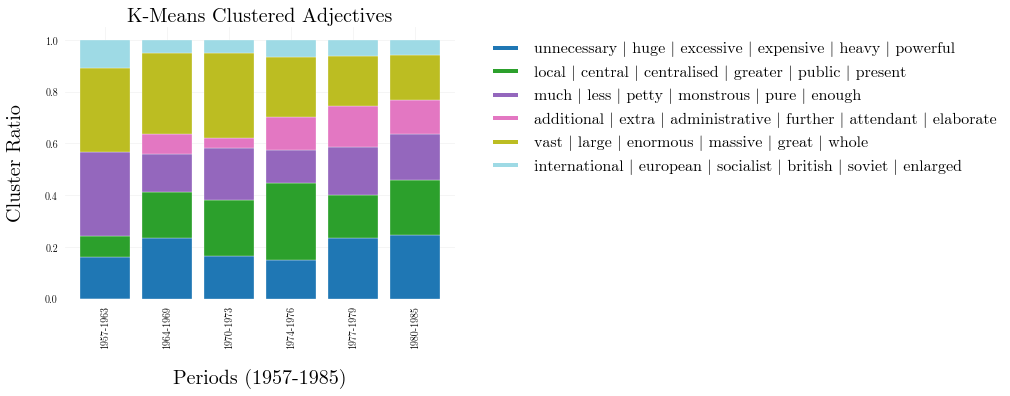

created list with 109 words


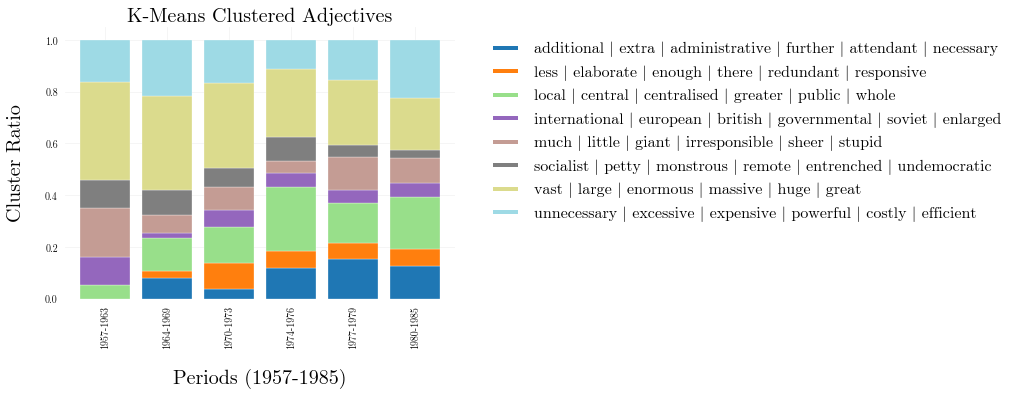

created list with 109 words


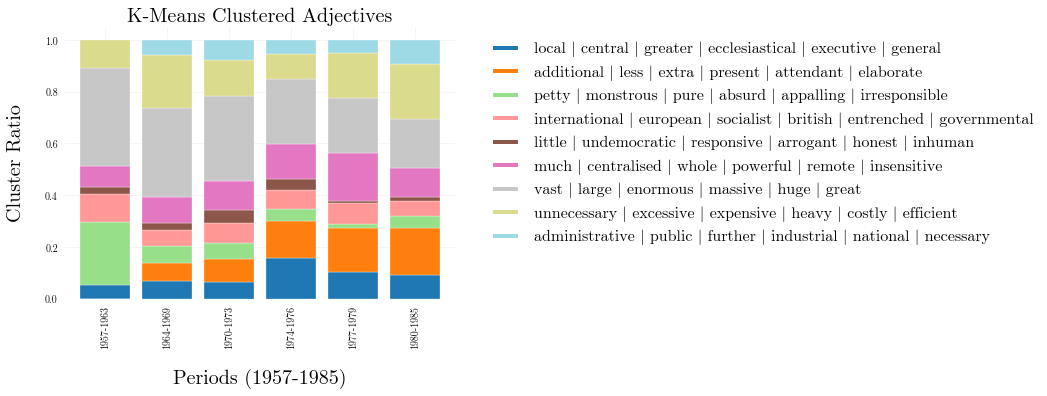

created list with 109 words


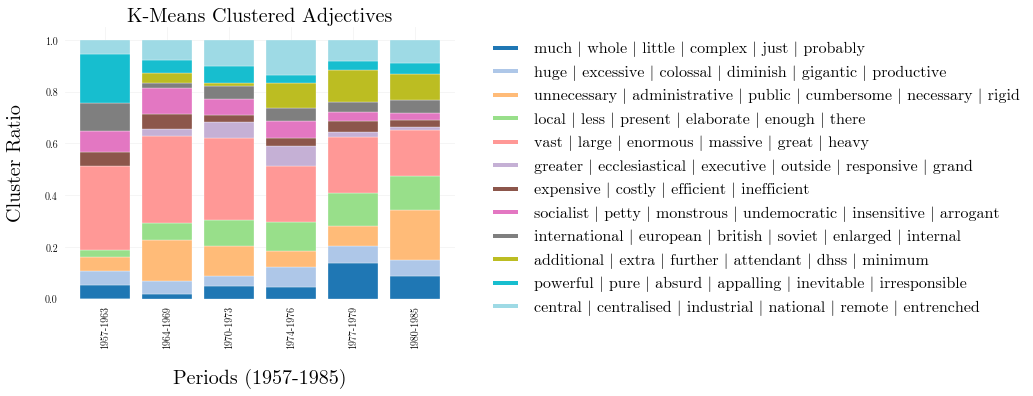

In [79]:
plotting.style()

for k in [6,8,9,12]:
    dm_ = dm(df,m,2,'adj')
    cd = cw(dm_,k)
    cn_ = cn(cd,df,'adj')
    
    # Combine
    coln = 'adj'
    clus_dict = cd 

    df = df[df['adj'].isin([k for k,v in clus_dict.items()])]
    cluster_sums_dict = dict()

    # Calculate Diachronic Sums of Clusters
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        tmpdf = df[df[coln].isin(list_words_cluster)]
        tmpdf_sums = list(tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=0))
        cluster_sums_dict.update({cluster_id:tmpdf_sums})

    for c in list(d.columns)[1:]:
        d[c] = d[c] / d[list(d.columns)[1:]].sum(axis=1)

    d = pd.DataFrame(cluster_sums_dict)
    d.columns = [cn_[str(x)] for x in d.columns]
    d['year'] = list(df.columns)[1:]
    d = d[['year'] + list(d.columns)[:-1]]

    d = d.T.reset_index()
    d.columns = list(d.iloc[0,:])
    d = d.iloc[1:,:]
    for c in list(d.columns)[1:]:
        d[c] = d[c] / d[c].sum()
    d = d.T.reset_index()
    d.columns = list(d.iloc[0,:])
    d = d.iloc[1:,:]

    p = d.plot.bar(x='year',y=list(d.columns)[1:],cmap='tab20',figsize=(7,5),stacked=True,width=0.8)
    leg = plt.legend(list(d.columns)[1:],bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(7.0)
    plt.title('K-Means Clustered Adjectives',fontsize=20)
    plt.xlabel('Periods (1957-1985)',labelpad=20)
    plt.ylabel('Cluster Ratio',labelpad=20)
    fig = p.get_figure()
    fig.savefig(f'/home/ruben/Documents/GitHub/CrisisBureaucracy/results/plots/clustered-adjectives-k{k}-threshold2.pdf',dpi=250, bbox_inches='tight')
    plt.show()

In [65]:
# # Get data and write to file
# data = getdata('bureaucratic')
# data = data.dropna()
# data = data.iloc[:,[1,2,7,9]].reset_index(drop=True)
# data.columns = "text id speaker party".split()
# data['id'] = ["__".join([data['speaker'][c].replace('uk.m.',''),data['party'][c].replace(' ','_'),x]) for c,x in enumerate(data['id'])]
# d = []
# for c,x in tqdm(enumerate(data['text'])):
#     for i in nlp(x):
#         if i.pos_ in ["NOUN", "PROPN"]:
#             comps = [j for j in i.children if j.pos_ in ["ADJ", "ADV"] and j.text == "bureaucratic"]
#             if comps:
#                 d.append([data['id'][c],str(i.text)])
# d = pd.DataFrame(d,columns='id adj'.split(' '))
# d.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/all-bureaucratic-adjectives-spacy.csv',index=False)

9437it [02:40, 58.91it/s]


In [58]:
df = pd.read_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/all-bureaucratic-adjectives-spacy.csv')
df['n'] = 1
df['year'] = df.id.str.split('proc.d.').str[1].str[:4].astype(int)
df = df[(df['year'] >= 1957) & (df['year'] < 1986)].reset_index(drop=True)
df = df["adj year n".split(' ')].groupby(['adj','year']).sum().reset_index().pivot(index='adj',columns='year',values='n').fillna(0.0).reset_index()

In [54]:
periods = [[1957,1963],[1964,1969],[1970,1973],[1974,1979],[1980,1985]]

for p in periods:
    p_ = "-".join([str(x) for x in p])
    pc = df[list(range(p[0],p[1]+1))].sum(axis=1)
    df[p_] = pc
df = df[['adj'] + list([x for x in df.columns if '-' in str(x)])]

created list with 198 words


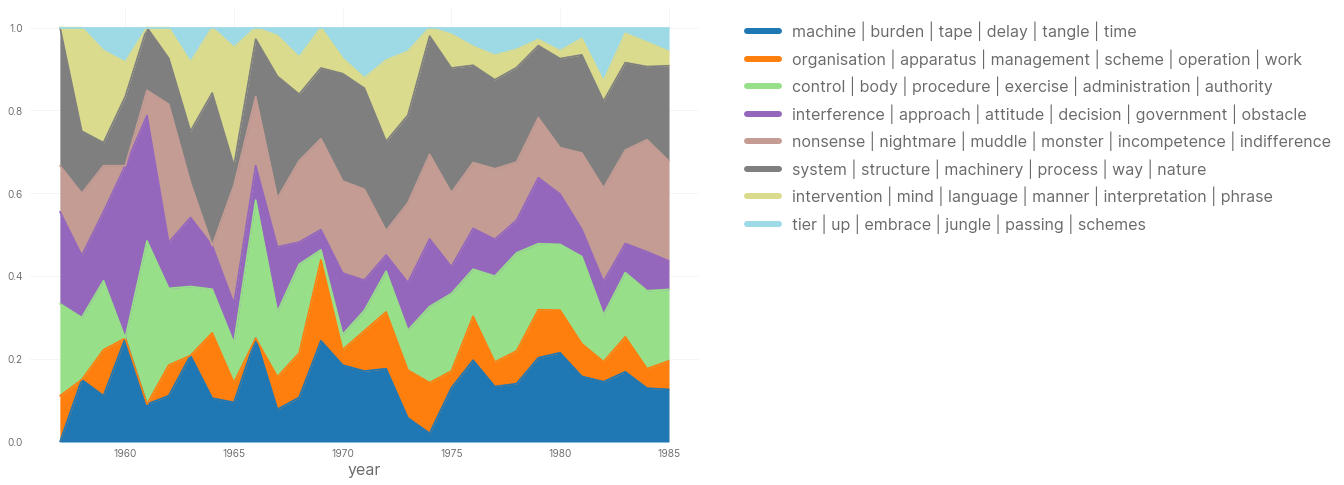

In [60]:
plotting.style(21)

dm_ = dm(df,m,2)
cd = cw(dm_,8)
cn_ = cn(cd,df)
d = plot_(cd,df,cn_,relative=True)

# for c in list(d.columns)[1:]:
#     d[c] = d[c] / d[list(d.columns)[1:]].sum(axis=1)
d.plot.area(x='year',y=list(d.columns)[1:],cmap='tab20',figsize=(12,8),stacked=True)
leg = plt.legend(list(d.columns)[1:],bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(6.0)
plt.show()